In [2]:
from __future__ import print_function
import os
import sys
import pandas as pd
import numpy as np

%matplotlib inline

from matplotlib import pyplot as plt
import seaborn as sns
import datetime

In [3]:
os.chdir('/home/akinyalcinkaya/Desktop/projeler-calismalarım/pythonstudying')

In [4]:
df=pd.read_csv('DataFiles/PRSA_data_2010.1.1-2014.12.31.csv')

In [5]:
print('Shape of the dataframe:',df.shape)

Shape of the dataframe: (43824, 13)


In [6]:
df.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [7]:
df['datetime']=df[['year','month','day','hour']].apply(lambda row:datetime.datetime(year=row['year'],month=row['month'],day=row['day'],hour=row['hour']),axis=1)
df.sort_values('datetime',ascending=True,inplace=True)

Text(0.5,1,u'Box plot of Air Pressure')

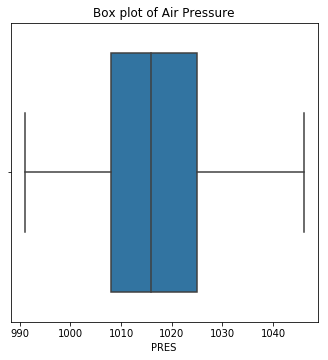

In [8]:
plt.figure(figsize=(5.5,5.5))
g=sns.boxplot(df['PRES'])
g.set_title('Box plot of Air Pressure')

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df['scaled_PRES']=scaler.fit_transform(np.array(df['PRES']).reshape(-1,1))

In [10]:
split_date=datetime.datetime(year=2014,month=1,day=1,hour=0)
df_train=df.loc[df['datetime']<split_date]
df_val=df.loc[df['datetime']>=split_date]
print('Shape of train:',df_train.shape)
print('Shape of test:',df_val.shape)

Shape of train: (35064, 15)
Shape of test: (8760, 15)


In [11]:
df_train.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,datetime,scaled_PRES
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0,2010-01-01 00:00:00,0.545455
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0,2010-01-01 01:00:00,0.527273
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0,2010-01-01 02:00:00,0.509091
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0,2010-01-01 03:00:00,0.509091
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0,2010-01-01 04:00:00,0.490909


In [12]:
df_val.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,datetime,scaled_PRES
35064,35065,2014,1,1,0,24.0,-20,7.0,1014.0,NW,143.48,0,0,2014-01-01 00:00:00,0.418182
35065,35066,2014,1,1,1,53.0,-20,7.0,1013.0,NW,147.50,0,0,2014-01-01 01:00:00,0.400000
35066,35067,2014,1,1,2,65.0,-20,6.0,1013.0,NW,151.52,0,0,2014-01-01 02:00:00,0.400000
35067,35068,2014,1,1,3,70.0,-20,6.0,1013.0,NW,153.31,0,0,2014-01-01 03:00:00,0.400000
35068,35069,2014,1,1,4,79.0,-18,3.0,1012.0,cv,0.89,0,0,2014-01-01 04:00:00,0.381818


In [13]:
df_val.reset_index(drop=True,inplace=True)

In [14]:
def makeXy(ts,nb_timesteps):
    
    X=[]
    y=[]
    
    for i in range(nb_timesteps,ts.shape[0]):
        X.append(list(ts.loc[i-nb_timesteps:i-1]))
        y.append(ts.loc[i])
    X,y=np.array(X),np.array(y)
    return X,y

In [15]:
X_train,y_train=makeXy(df_train['scaled_PRES'],7)
print('Shape of train arrays:',X_train.shape,y_train.shape)

Shape of train arrays: (35057, 7) (35057,)


In [ ]:
X_val,y_val=makeXy(df_val['scaled_PRES'],7)
print('Shape of validation arrays:',X_val.shape,y_val.shape)

In [75]:
X_train,X_val=X_train.reshape((X_train.shape[0],X_train.shape[1],1)),X_val.reshape((X_val.shape[0],X_val.shape[1],1))
    
print('Shape of 3D arrays:',X_train.shape,y_val.shape)

Shape of 3D arrays: (35057, 7, 1) (8753,)


In [76]:
from keras.layers import Dense, Input, Dropout
from keras.layers.recurrent import GRU
from keras.optimizers import SGD
from keras.models import Model
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

In [77]:
input_layer=Input(shape=(7,1),dtype='float32')


In [78]:
gru_layer=GRU(64,input_shape=(7,1),return_sequences=False)(input_layer)

In [79]:
droput_layer=Dropout(0.2)(gru_layer)

In [80]:
output_layer=Dense(1,activation='linear')(droput_layer)

In [81]:
ts_model=Model(inputs=input_layer,outputs=output_layer)
ts_model.compile(loss='mse',optimizer='adam')
ts_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 7, 1)              0         
_________________________________________________________________
gru_2 (GRU)                  (None, 64)                12672     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 12,737
Trainable params: 12,737
Non-trainable params: 0
_________________________________________________________________


NameError: name 'ts_model' is not defined

In [92]:
model = load_model('my_model.h5')
preds = model.predict(X_val)
pred_PRES = scaler.inverse_transform(preds)
pred_PRES = np.squeeze(pred_PRES)


IOError: Unable to open file (Unable to open file: name = 'my_model.h5', errno = 2, error message = 'no such file or directory', flags = 0, o_flags = 0)